In [5]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [6]:
from os.path import exists

In [7]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
import PIL
print(PIL.__version__)

7.0.0


In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/kt_ish_train.zip -d train
!unzip -q /content/gdrive/MyDrive/kt_ish_val.zip -d val

In [12]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Jan 25 21:24:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [14]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [18]:
unlabeler = LabelEncoder()
labels = [path.parent.name for path in train_files]
unlabeler.fit(labels)
with open('label_ish_smalla_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [50]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = torch.FloatTensor([1 if path.parent.name=="ишемия" else 0 for path in self.files])
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [51]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [52]:
import random

In [16]:
TRAIN_DIR = Path('train/kt_ish_train')
train_files = list(TRAIN_DIR.rglob('*.jpg'))
random.shuffle(train_files)
print(train_files)

[PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_POLSHKOVA_E.M\u200e_(83y)_-_26.09.2020_3_00_26_-_soft_0039.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_AMARYAN_G_U\u200e_(63y)_-_28.09.2020_9_29_01_-_Head__1.5__J30s_0005.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_MEDVEDEV_A_A\u200e_(42y)_-_18.10.2020_9_24_04_-_STD_1.25mm_0112.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_IVANOV_V_N\u200e_(58y)_-_16.10.2020_14_30_50_-_Head__1.5__J30s_0035.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_TVERYKOV_S.V.\u200e_(50y)_-_24.10.2020_13_45_35_-_Cerebrum__1.5__H31s_0134.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_POROSHIN_A_I\u200e_(70y)_-_22.09.2020_22_21_32_-_Head__1.5__J30s_0047.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_SARIPOVA_E_V\u200e_(48y)_-_19.10.2020_12_01_00_-__Head_0.5_0059.jpg'), PosixPath('train/kt_ish_train/ишемия отсутствует/3D_MPR_-_Sokolov__A.V\u200e

In [17]:
VAL_DIR = Path('val/kt_ish_val')
val_files=list(VAL_DIR.rglob('*.jpg'))
random.shuffle(val_files)
print(val_files)

[PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0040.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_ANTIPOVA_V.N.\u200e_(75y)_-_09.10.2020_7_24_01_-_SFT_0.625_0045.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_KOLESNIKOVA_I_N\u200e_(62y)_-_18.10.2020_23_11_23_-__Head_0.5_0041.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0007.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_GULAKOVA_G_T\u200e_(65y)_-_23.09.2020_11_13_04_-_Head__1.0__J30s_0109.jpg'), PosixPath('val/kt_ish_val/ишемия/3D_MPR_-_MITYUKHLYAEV_B_I\u200e_(81y)_-_01.10.2020_12_28_36_-__Head_0.5_0088.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0004.jpg'), PosixPath('val/kt_ish_val/ишемия отсутствует/3D_MPR_-_KOLESNIKOVA_I_N\u200e_(62y)_-_18.10.2020_23_11_23_-__Head_0.5_0061

In [53]:
val_dataset = KTDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

351


In [54]:
train_dataset = KTDataset(train_files, mode = 'train', encoder=unlabeler)

In [55]:
print(len(train_files))

10434


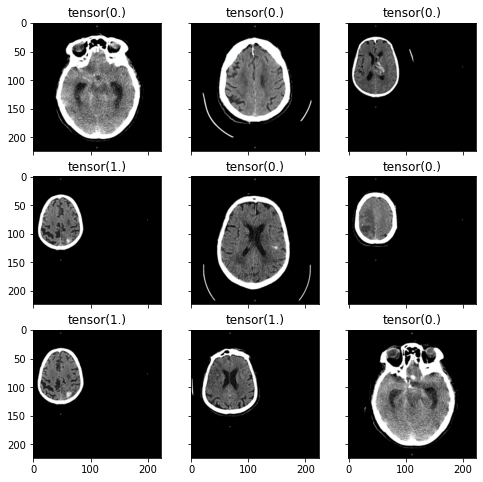

In [56]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [34]:
import torch.nn as nn

class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.out = nn.Linear(32, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # print(x.shape)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [57]:
from torchvision import datasets, models, transforms

num_classes=1
torch.manual_seed(42)
np.random.seed(42)

base_model=SmallCnn(num_classes)

base_model=base_model.to(DEVICE)

# loss_fn = f1_loss

# optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        try:
            outputs=torch.reshape(outputs, (64,))
        except:
            outputs=torch.reshape(outputs, (2,))
        # print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # all_f1=0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            try:
                outputs=torch.reshape(outputs, (64,))
            except:
                outputs=torch.reshape(outputs, (31,))
            
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 0)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        # f1_metr=f1_score(labels.cpu(), preds.cpu(), average=None)
        # all_f1+=f1_metr
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # f1_result=all_f1/processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_binary_ish_smalla_"+str(epoch+1)+".pth")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(base_model)

In [58]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.3693463382351689


epoch:   3%|▎         | 1/30 [04:05<1:58:43, 245.64s/it]


Epoch 001 train_loss: 0.3693     val_loss 0.5533 train_acc 0.0178 val_acc 0.1823
loss 0.2842343818508439


epoch:   7%|▋         | 2/30 [08:10<1:54:31, 245.41s/it]


Epoch 002 train_loss: 0.2842     val_loss 0.6191 train_acc 0.0129 val_acc 0.0000
loss 0.17822172730527025


epoch:  10%|█         | 3/30 [12:15<1:50:23, 245.33s/it]


Epoch 003 train_loss: 0.1782     val_loss 0.7990 train_acc 0.0120 val_acc 0.0000
loss 0.07034435683748196


epoch:  13%|█▎        | 4/30 [16:20<1:46:18, 245.31s/it]


Epoch 004 train_loss: 0.0703     val_loss 1.0460 train_acc 0.0079 val_acc 0.0000
loss 0.025805676681152984


epoch:  17%|█▋        | 5/30 [20:26<1:42:12, 245.32s/it]


Epoch 005 train_loss: 0.0258     val_loss 1.3765 train_acc 0.0141 val_acc 0.0000
loss 0.011283726418754688


epoch:  20%|██        | 6/30 [24:32<1:38:15, 245.65s/it]


Epoch 006 train_loss: 0.0113     val_loss 1.8098 train_acc 0.0070 val_acc 0.0000
loss 0.0051433446429170315


epoch:  23%|██▎       | 7/30 [28:37<1:34:03, 245.39s/it]


Epoch 007 train_loss: 0.0051     val_loss 2.3912 train_acc 0.0183 val_acc 0.0000
loss 0.0030949825101608984


epoch:  27%|██▋       | 8/30 [32:42<1:29:54, 245.21s/it]


Epoch 008 train_loss: 0.0031     val_loss 2.7888 train_acc 0.0244 val_acc 0.0000
loss 0.006042914004549909


epoch:  30%|███       | 9/30 [36:46<1:25:46, 245.05s/it]


Epoch 009 train_loss: 0.0060     val_loss 2.1284 train_acc 0.0045 val_acc 0.0000
loss 0.0005391021837523746


epoch:  33%|███▎      | 10/30 [40:55<1:22:00, 246.02s/it]


Epoch 010 train_loss: 0.0005     val_loss 2.3780 train_acc 0.0311 val_acc 0.0000
loss 0.0002796873937630324


epoch:  37%|███▋      | 11/30 [44:59<1:17:46, 245.63s/it]


Epoch 011 train_loss: 0.0003     val_loss 2.7390 train_acc 0.0121 val_acc 0.0000
loss 0.00018102254474688037


epoch:  40%|████      | 12/30 [49:03<1:13:30, 245.01s/it]


Epoch 012 train_loss: 0.0002     val_loss 2.6766 train_acc 0.0256 val_acc 0.0000
loss 0.00014300055398018622


epoch:  43%|████▎     | 13/30 [53:06<1:09:16, 244.52s/it]


Epoch 013 train_loss: 0.0001     val_loss 2.9222 train_acc 0.0220 val_acc 0.0000
loss 0.00012807455796397162


epoch:  47%|████▋     | 14/30 [57:09<1:05:03, 243.94s/it]


Epoch 014 train_loss: 0.0001     val_loss 2.7979 train_acc 0.0066 val_acc 0.0000
loss 9.167994525424067e-05


epoch:  50%|█████     | 15/30 [1:01:12<1:00:54, 243.65s/it]


Epoch 015 train_loss: 0.0001     val_loss 2.8598 train_acc 0.0172 val_acc 0.0000
loss 7.779256440436904e-05


epoch:  53%|█████▎    | 16/30 [1:05:15<56:47, 243.41s/it]


Epoch 016 train_loss: 0.0001     val_loss 2.9873 train_acc 0.0195 val_acc 0.0000
loss 6.745923111388261e-05


epoch:  57%|█████▋    | 17/30 [1:09:18<52:42, 243.28s/it]


Epoch 017 train_loss: 0.0001     val_loss 3.0474 train_acc 0.0118 val_acc 0.0000
loss 5.7855354375410446e-05


epoch:  60%|██████    | 18/30 [1:13:20<48:36, 243.04s/it]


Epoch 018 train_loss: 0.0001     val_loss 3.0246 train_acc 0.0194 val_acc 0.0000
loss 4.981089923397864e-05


epoch:  63%|██████▎   | 19/30 [1:17:23<44:32, 242.98s/it]


Epoch 019 train_loss: 0.0000     val_loss 3.1732 train_acc 0.0130 val_acc 0.0000
loss 4.4150630985172006e-05


epoch:  67%|██████▋   | 20/30 [1:21:27<40:31, 243.17s/it]


Epoch 020 train_loss: 0.0000     val_loss 3.0725 train_acc 0.0154 val_acc 0.0000
loss 3.917359920338059e-05


epoch:  70%|███████   | 21/30 [1:25:30<36:29, 243.33s/it]


Epoch 021 train_loss: 0.0000     val_loss 3.2002 train_acc 0.0145 val_acc 0.0000
loss 3.4468558899483805e-05


epoch:  73%|███████▎  | 22/30 [1:29:33<32:25, 243.19s/it]


Epoch 022 train_loss: 0.0000     val_loss 3.2359 train_acc 0.0068 val_acc 0.0000
loss 3.06377905371733e-05


epoch:  77%|███████▋  | 23/30 [1:33:36<28:21, 243.10s/it]


Epoch 023 train_loss: 0.0000     val_loss 3.2982 train_acc 0.0108 val_acc 0.0000
loss 2.677977166204751e-05


epoch:  80%|████████  | 24/30 [1:37:39<24:17, 242.93s/it]


Epoch 024 train_loss: 0.0000     val_loss 3.2647 train_acc 0.0219 val_acc 0.0000
loss 2.4539873143861104e-05


epoch:  83%|████████▎ | 25/30 [1:41:41<20:14, 242.82s/it]


Epoch 025 train_loss: 0.0000     val_loss 3.3603 train_acc 0.0361 val_acc 0.0000
loss 2.1443847035267526e-05


epoch:  87%|████████▋ | 26/30 [1:45:44<16:11, 242.79s/it]


Epoch 026 train_loss: 0.0000     val_loss 3.3614 train_acc 0.0126 val_acc 0.0000
loss 1.9326206120597767e-05


epoch:  90%|█████████ | 27/30 [1:49:47<12:08, 242.72s/it]


Epoch 027 train_loss: 0.0000     val_loss 3.4007 train_acc 0.0334 val_acc 0.0000
loss 1.7252499878880866e-05


epoch:  93%|█████████▎| 28/30 [1:53:49<08:05, 242.58s/it]


Epoch 028 train_loss: 0.0000     val_loss 3.3725 train_acc 0.0083 val_acc 0.0000
loss 1.537927808239833e-05


epoch:  97%|█████████▋| 29/30 [1:57:51<04:02, 242.55s/it]


Epoch 029 train_loss: 0.0000     val_loss 3.4655 train_acc 0.0127 val_acc 0.0000
loss 1.388326498276547e-05


epoch: 100%|██████████| 30/30 [2:01:54<00:00, 243.81s/it]


Epoch 030 train_loss: 0.0000     val_loss 3.5100 train_acc 0.0245 val_acc 0.0000


In [59]:
loss, acc, val_loss, val_acc = zip(*history)

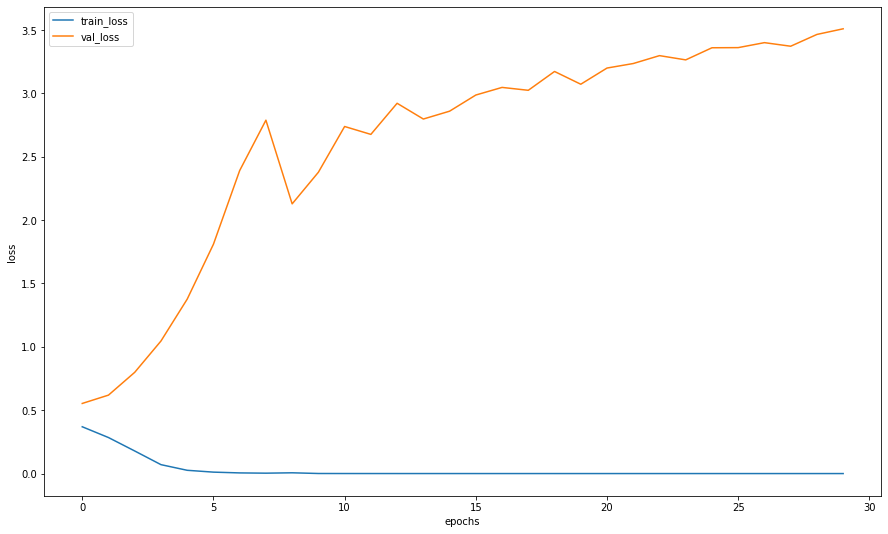

In [60]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [61]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [62]:
random_characters = int(np.random.uniform(0,260))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [63]:
idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [64]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

In [65]:
# actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)

[tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), ten

In [66]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


array([0.80239521, 0.        ])

In [67]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    print(logits)
    probs = nn.functional.sigmoid(torch.cat(logits)).numpy()
    probs = [1 if i>=0.5 else 0 for i in probs]
    return probs

idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)
print(probs_ims)

actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score

print(actual_labels)
print(probs_ims)
print(f1_score(actual_labels, probs_ims, average=None))

nice=0
for i in range(100):
    if actual_labels[i]==probs_ims[i]:
      nice+=1
print(nice)

[tensor([[-12.8786]]), tensor([[-2.9862]]), tensor([[-0.0113]]), tensor([[-40.6980]]), tensor([[-14.1562]]), tensor([[-8.1874]]), tensor([[-25.3272]]), tensor([[-12.5175]]), tensor([[-0.4588]]), tensor([[-20.0169]]), tensor([[-28.0333]]), tensor([[-39.4917]]), tensor([[-37.6066]]), tensor([[-12.5096]]), tensor([[-41.1606]]), tensor([[-16.7226]]), tensor([[-18.2911]]), tensor([[-40.3834]]), tensor([[-4.2986]]), tensor([[-15.7008]]), tensor([[-40.3834]]), tensor([[-1.8348]]), tensor([[-36.1885]]), tensor([[-12.5175]]), tensor([[-5.9257]]), tensor([[-38.6185]]), tensor([[-40.3359]]), tensor([[-6.4942]]), tensor([[-0.0113]]), tensor([[-8.0181]]), tensor([[-12.9128]]), tensor([[-35.3071]]), tensor([[2.3190]]), tensor([[-42.0388]]), tensor([[0.2053]]), tensor([[-0.0241]]), tensor([[-28.4195]]), tensor([[-0.9720]]), tensor([[-47.9167]]), tensor([[-44.1895]]), tensor([[-14.1562]]), tensor([[-4.7739]]), tensor([[-6.1833]]), tensor([[-17.7393]]), tensor([[-4.2528]]), tensor([[-14.7833]]), tensor

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), ten

IndexError: ignored

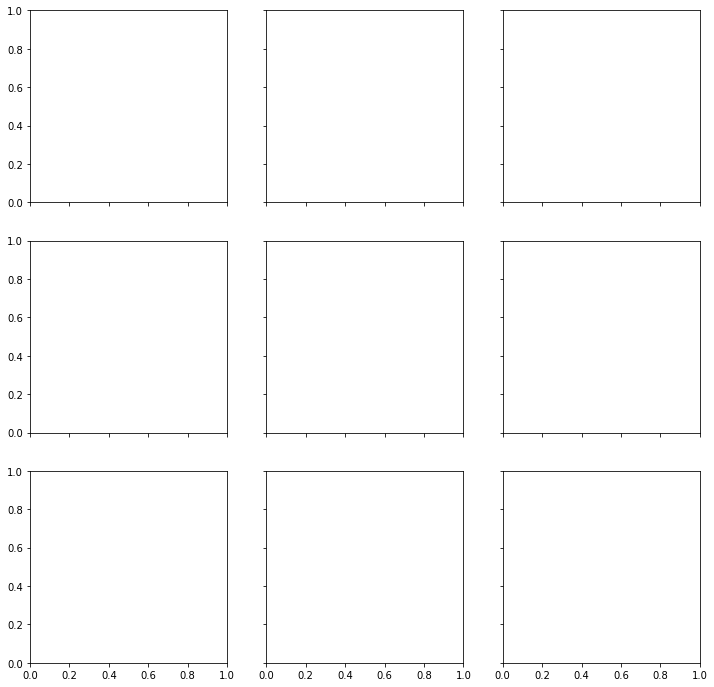

In [49]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
torch.save(base_model.state_dict(), "gdrive/MyDrive/KT_binary_ish_smalla_v2_last.pth")

In [ ]:
def predict_picture(file_name):
    TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

    test_files = list(TEST_DIR.rglob(file_name))

    test_dataset = KTDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(base_model, test_loader)
    print(probs)
    predicted_proba = np.max(probs)*100
    for i in range(len(probs[0])):
      print(probs[0][i]*100, label_encoder.classes_[i])
    y_pred = np.argmax(probs)
    predicted_label = label_encoder.classes_[y_pred]
    return predicted_label, predicted_proba

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(predict_picture("10.jpg"))

[[2.3849365e-05 7.8634754e-02 9.4841748e-02 3.5471048e-02 3.6185865e-09
  9.6606191e-06 1.3273510e-01 2.4622777e-03 3.6915779e-08 1.2144416e-04
  3.2435180e-04 4.2660564e-02 6.1262834e-01 8.6691303e-05]]
0.0023849364879424684 ВЖК
7.8634753823280334 ВМГ 1
9.484174847602844 ВМГ 2
3.5471048206090927 ВМГ_ВЖК
3.6185865415205853e-07 ВМГ_ВЖК_САК
0.0009660619070928078 ВМГ_ВЖК_ишем
13.273510336875916 ВМГ_ишемия
0.24622776545584202 САК
3.6915778878210403e-06 САК_ВЖК
0.01214441581396386 САК_ВМГ
0.03243518003728241 СД
4.266056418418884 ишемия
61.26283407211304 опухоль
0.008669130329508334 эд_сд
('опухоль', 61.26283407211304)


In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

val_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
print(val_files)

[PosixPath('/content/gdrive/MyDrive/kt_test_fold/2.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/3.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/1.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/4.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/5.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/6.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/7.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/8.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/9.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/10.jpg')]


In [ ]:
val_dataset = KTDataset(val_files, mode='val')

In [ ]:
print(len(val_dataset))

10


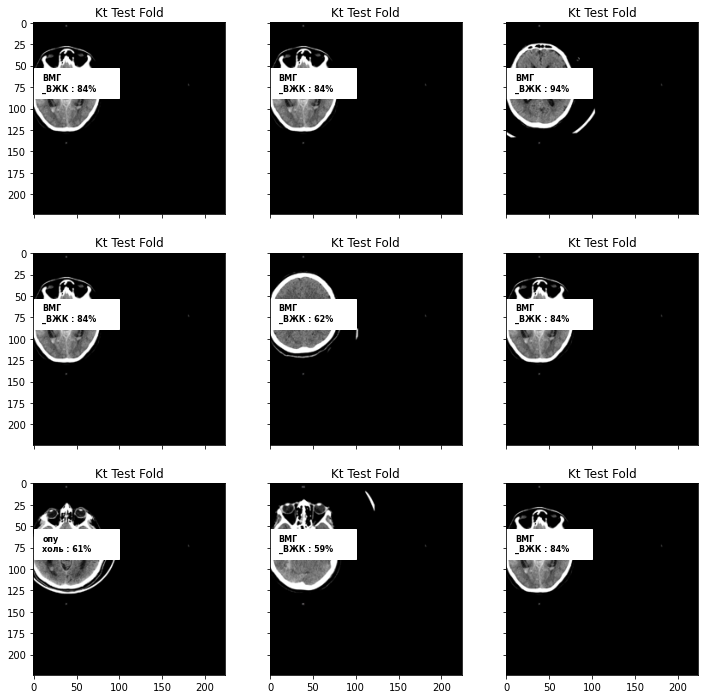

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

test_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
test_dataset = KTDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(base_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [ ]:
print(preds)

['ВМГ_ВЖК' 'опухоль' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ 2'
 'ишемия' 'ВМГ_ВЖК' 'ВМГ_ВЖК']


In [ ]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))